In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

/home/sergioms/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from DeepST import DeepST

In [3]:
adata=sc.read('../../data/processed_adata/adata_msbrain_3rep_withclusters_only_nuclei_deep_annotation_with_colors.h5ad')

In [4]:
DeepST.preprocess(adata)

/home/sergioms/.local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [5]:
import numpy as np
adata.obsm['spatial']=np.array(adata.obs.loc[:,['x_centroid','y_centroid']])

In [6]:
adata=adata[adata.obs['replicate']=='1']

In [7]:
from DeepST.preprocess import construct_interaction_KNN
construct_interaction_KNN(adata)

Graph constructed!


In [9]:
# build graph
DeepST.add_contrastive_label(adata)

In [10]:
# get features
DeepST.get_feature(adata)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DeepST.Train(adata, datatype='Stereo', device=device)
adata.obsm['emb'] = model.train()

Building sparse matrix ...
Begin to train ST data...


100%|█████████████████████████████████████████████████████████████████████████████████| 600/600 [38:12<00:00,  3.82s/it]


Optimization finished for ST data!


In [16]:
adata.obsm['emb'].shape

(25695, 284)

In [14]:
# clustering
from DeepST.utils import clustering
clustering(adata, 40, datatype='Stereo', refinement=False)

ModuleNotFoundError: No module named 'rpy2'

In [47]:
sc.pp.neighbors(adata,use_rep='emb',n_neighbors=8)

In [56]:
sc.tl.leiden(adata,resolution=0.8,key_added='deepst') #this one returns 36 clusters, which is the desired

In [19]:
sc.tl.umap(adata)

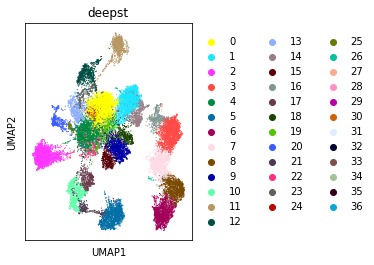

In [57]:
sc.pl.umap(adata,color='deepst')

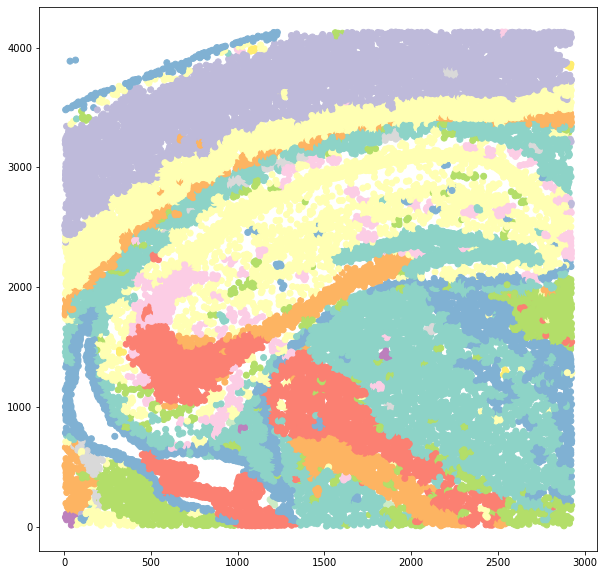

In [58]:
plt.figure(figsize=(10,10))
import matplotlib.pyplot as plt
plt.scatter(adata.obs['x_centroid'],adata.obs['y_centroid'],c=adata.obs['deepst'].astype(int),cmap='Set3')

Text(0.5, 1.0, 'Mouse Embryo E9.5')

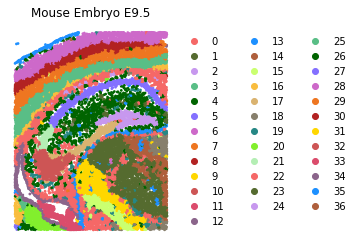

In [59]:
import matplotlib.pyplot as plt
#adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (3, 4)
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
            "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
            "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
           "#877F6C","#268785", '#82EF2D', '#B4EEB4']

ax = sc.pl.embedding(adata, basis="spatial",
                     color="deepst",
                     s=30,
                     show=False,
                     palette=plot_color,
                     title='DeepST')
ax.axis('off')
ax.set_title('Mouse Embryo E9.5')

In [60]:
adata.write('../../figures/7.spatial_architecture/deepst_adata_msbrain_rep1.h5')